## Setup

In [1]:
#clone repo
!git clone https://github.com/jonmarks12/ML-FSM.git
%cd ML-FSM

import sys
sys.path.append('/content/ML-FSM')


Cloning into 'ML-FSM'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 106 (delta 29), reused 82 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (106/106), 13.63 MiB | 17.94 MiB/s, done.
Resolving deltas: 100% (29/29), done.
/content/ML-FSM


In [2]:
!pip install pytorch-lightning==2.4.0
!pip install ase geometric
!pip install py3Dmol
import py3Dmol
import ipywidgets as widgets
from IPython.display import display
from IPython.display import HTML
import matplotlib.pyplot as plt
import os
import ase
import shutil
import argparse
import numpy as np
from cos import FreezingString
from geom import calculate_arc_length
from opt import CartesianOptimizer, InternalsOptimizer
from utils import load_xyz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 819.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 67.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlin

In [3]:
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-spline-conv -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-geometric==2.0.3

2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 101.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.4/370.4 kB 25.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.1/565.1 kB 39.6 MB/s eta 0:00:00


## Manually load reactant and product

In [24]:
reactant = ase.Atoms(symbols=['C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
                    positions=[
                    [-0.7630691361, -0.0020190208,  0.0034566355],
                    [ 0.7626325757,  0.0019950530,  0.0009730411],
                    [-1.1589043116, -0.5118960388,  0.8883793728],
                    [ 1.1613211937,  0.5116793524,  0.8847263259],
                    [-1.1629572511,  1.0174805269,  0.0041985317],
                    [-1.1617577754, -0.5117033851, -0.8802966057],
                    [ 1.1625206820, -1.0175044968,  0.0002310876],
                    [ 1.1584677813,  0.5118721300, -0.8839496535],
                    ]
                     )
product = ase.Atoms(symbols=['C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
                     positions=[
                    [ 0.8250132507, -0.3044255156, -0.0001793369],
                    [-0.0708590455,  0.6761106267, -0.0016038483],
                    [-2.2168320223, -1.1357962646,  0.0051867426],
                    [-2.9069107362, -1.4149124935,  0.0006665373],
                    [ 1.2144012074, -0.7244594455, -0.9242788205],
                    [ 1.2098231719, -0.7260043834,  0.9251338654],
                    [-0.4588134959,  1.0959757755,  0.9230324730],
                    [-0.4554227885,  1.0988459975, -0.9270321510],
                    ]
                     )

#alternatively load one of the reactions in our benchmark set
reactant, product = load_xyz("data/wb97x_sharada/06_diels_alder/")

#Run FSM

In [25]:
#parameters
nnodes_min = 18
interp = 'ric'
ninterp = 50
method = 'L-BFGS-B'
maxiter = 1
maxls = 3
dmax = 0.3

#load calculator
ckpt = "gnns/schnet_fine_tuned.ckpt"
from schnet_ase_calculator import SchNetCalculator
calc = SchNetCalculator(checkpoint = ckpt)

# string class
string = FreezingString(reactant, product, nnodes_min, interp, ninterp)

# optimizer class
optimizer = CartesianOptimizer(calc, method, maxiter, maxls, dmax)

# run
while (string.growing):
    string.grow()
    string.optimize(optimizer)
print("Gradient calls:", string.ngrad)

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.9 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint gnns/schnet_fine_tuned.ckpt`


NNODES_MIN: 18
DIST: 4.679 STEPSIZE: 0.260
Gradient calls: 55


## Plotting and Visualization

In [26]:
all_atoms = string.r_string+string.p_string[::-1]
all_energies = np.array(string.r_energy+string.p_energy[::-1])
all_energies = (all_energies-min(all_energies))
ts_idx = all_energies.argmax()
path = [structure.get_positions() for structure in all_atoms]
s = calculate_arc_length(np.array(path))

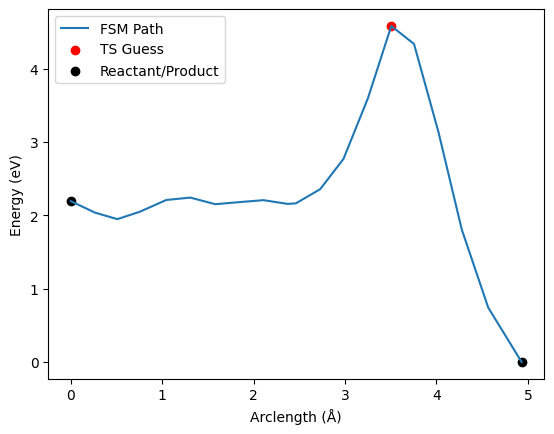

In [27]:
plt.plot(s,all_energies,label='FSM Path')
plt.scatter(s[ts_idx],all_energies[ts_idx],color='red',label='TS Guess')
plt.scatter(s[0],all_energies[0],color='black',label='Reactant/Product')
plt.scatter(s[-1],all_energies[-1],color='black')
plt.xlabel('Arclength (Å)')
plt.ylabel('Energy (eV)')
plt.legend()
plt.show()

In [28]:
from IPython.display import HTML

def snapshot_row(atoms_list, labels=None):
    html_str = ""
    for i, atoms in enumerate(atoms_list):
        symbols = atoms.get_chemical_symbols()
        positions = atoms.get_positions()

        xyz_str = f"{len(atoms)}\n\n"
        for sym, pos in zip(symbols, positions):
            xyz_str += f"{sym} {pos[0]} {pos[1]} {pos[2]}\n"

        view = py3Dmol.view(width=250, height=250)
        view.addModel(xyz_str, 'xyz')
        view.setStyle({'stick': {'radius': 0.2}, 'sphere': {'radius': 0.6}})
        view.zoomTo()

        # Generate label and viewer together
        label_text = labels[i] if labels else f"Frame {i}"
        viewer_html = view._make_html()

        # Combine label and viewer in a single column
        html_str += f"""
                  <div style='display:flex;flex-direction:column;align-items:center;margin-right:10px'>
                      <div style='font-weight:bold;margin-bottom:4px;text-align:center'>{label_text}</div>
                      {viewer_html}
                  </div>
                  """


    return HTML(f"<div style='display:flex;gap:10px'>{html_str}</div>")

# Example usage
frames_to_show = [all_atoms[0], all_atoms[ts_idx], all_atoms[-1]]
custom_labels = ['Reactant<br> Relative Energy: {:.1f} eV'.format(all_energies[0]),
                 'TS Guess<br> Relative Energy: {:.1f} eV'.format(all_energies[ts_idx]),
                 'Product<br> Relative Energy: {:.1f} eV'.format(all_energies[-1])]
snapshot_row(frames_to_show, custom_labels)
